1) comment on catégoriser le taux d'influence: t-stat
2) is movie significant ? -> p-value
3) same release year for several movies -> keep the one that is the most rated (number of ratings)
4) keep categories of 5 : top 5, most 5 popular movies which are not significant, bottom 5
5) remove all movies that have less than 100 ratings (to be determined maybe we discard too many movies or too litte...)
6) remove all characters that have an order below the median (or mean) of the number of character in the movie.
7) Careful : the number of movies with significant impact on baby names may drop a lot due to the point 5 and 6
8) the point 5 and 6 must be done also for the global study and not only for the website interactive heading (TO BE DISCUSSED!!)

In [216]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [217]:
folder_processed_data_path = './processed_data/'

# import the name_by_movie dataframe
name_by_movie_df = pd.read_csv(os.path.join(folder_processed_data_path, 'name_by_movie_ordered_df.csv'))
name_by_movie_df.set_index(['wiki_ID', 'char_words', 'gender'], inplace=True)
display(name_by_movie_df.sample(2))

# import the movie dataframe
movie_df = pd.read_csv(os.path.join(folder_processed_data_path, 'movie_df.csv'))
movie_df.set_index(['wiki_ID'], inplace=True)
display(movie_df.sample(2))

# import the baby names dataframe
baby_name_df = pd.read_csv(os.path.join(folder_processed_data_path, 'baby_name_df.csv'))
baby_name_df.set_index(['name', 'year'], inplace=True)

# create dataframe containing the release year of each movie
release_year_df = movie_df[['year', 'numVotes']].copy(deep=True)
display(release_year_df.sample(2))

# import the name_by_movie with the slope difference
name_by_movie_slope_diff_df = pd.read_csv(os.path.join(folder_processed_data_path, 'name_by_movie_ordered_pvalue_10_5_df.csv'))
name_by_movie_slope_diff_df.set_index(['wiki_ID', 'char_words', 'gender'], inplace=True)
display(name_by_movie_slope_diff_df.sample(2))

,,,order
wiki_ID,char_words,gender,
5071341,Buddy,M,NaN
24885677,Amma,F,NaN


,mov_name,year,month,revenue,numVotes,averageRating,poster_url
wiki_ID,,,,,,,
35571731,Kaanch Ki Deewar,1986,1.0,NaN,19,4.2,NaN
28847751,Even the Rain,2010,9.0,558342.0,14073,7.4,https://images-na.ssl-images-amazon.com/images...


,year,numVotes
wiki_ID,,
23400232,1935,36
7488465,1934,309


,,,order,p_value,slope_change,t_stat
wiki_ID,char_words,gender,,,,
337740,Jonathan,M,2.0,0.758010,0.003882,-0.315875
32162913,Lila,F,4.0,0.059812,0.005279,-2.097950


# Data processing for the website
In this notebook, we filter the `name_by_movie` dataframe in order to remove the movie character too little known to have had an impact on the baby names. We will assess the popularity of the charcter based on the number of IMDB ratings of the movie and whether its role was important by using the `order` attribute.

In addition, an issue related to the limitation of the data is assessed here. The problem is that for two movies released the same year that has the same name for one of their character, we can't tell which of them had an impact on the name given to babies. To assess this problem, we will keep only the most popular movie based on the number of IMDB ratings.

### Filtering of `name_by_movie` : number of ratings

First, let's remove the character names of movies with less than 100 IMDB ratings.

In [218]:
name_by_movie_df.reset_index(inplace=True)
movie_df.reset_index(inplace=True)

name_by_movie_df_merged = name_by_movie_df.merge(release_year_df, left_on='wiki_ID', right_on='wiki_ID', how = 'left') # TODO : should I make a deep copy?
print(f"length of the initial dataframe : {len(name_by_movie_df)}")
print(f"length of the merged dataframe : {len(name_by_movie_df_merged)}")
display(name_by_movie_df_merged.sample(2))

length of the initial dataframe : 172906
length of the merged dataframe : 172906


,wiki_ID,char_words,gender,order,year,numVotes
57363,3654363,Jules,M,11.0,1948,5664
114665,18089458,Wan,F,NaN,2006,493


In [219]:
name_by_movie_df_merged_filter_nbratings = name_by_movie_df_merged[name_by_movie_df_merged['numVotes'] >= 1000].copy(deep=True)
print(f"length of the initial dataframe : {len(name_by_movie_df)}")
print(f"length of the filtered dataframe : {len(name_by_movie_df_merged_filter_nbratings)}")

length of the initial dataframe : 172906
length of the filtered dataframe : 119881


### Filtering of `name_by_movie`  : importance of the role

Now, lets remove the character names with an minor role in the movie. We will keep only the characters with a order higher or equal to the median of the set of order in the movie. First, let's compute the number of order for each movies.

In [220]:
# is it normal that not all the movies in movies_df have at least one character in name_by_movie_df ? TODO
# display(movie_df[movie_df['wiki_ID'] == 844398])
# display(name_by_movie_df[name_by_movie_df['wiki_ID'] == 844398])

In [221]:
name_by_movie_merged_groupby = name_by_movie_df_merged_filter_nbratings.groupby(['wiki_ID'])
name_by_movie_merged_nunique = name_by_movie_merged_groupby['order'].nunique()

# check for a specific movie
test_movie_id = 617063

for movie_id, group in name_by_movie_merged_groupby:
    if(movie_id == (test_movie_id,)):
        print('movie_id', movie_id)
        print('group', group)

print(f"number of unique order = {name_by_movie_merged_nunique[test_movie_id]}")
name_by_movie_merged_nunique = name_by_movie_merged_nunique.to_frame()
name_by_movie_merged_nunique.rename(columns={"order": "nb_order"}, inplace=True)
display(name_by_movie_merged_nunique)

movie_id (617063,)
group        wiki_ID char_words gender  order  year  numVotes
18105   617063    Kennedy      M    1.0  2002     61167
18106   617063     Cassie      F    0.0  2002     61167
18107   617063     Olivia      F   11.0  2002     61167
18108   617063    Haywood      M    2.0  2002     61167
18109   617063      Elder      F    8.0  2002     61167
18110   617063       Cody      M    6.0  2002     61167
18111   617063        Ray      M    5.0  2002     61167
18112   617063         Al      M    7.0  2002     61167
18113   617063        Rod      M    6.0  2002     61167
18114   617063     Justin      M    3.0  2002     61167
18115   617063    Swanson      M    7.0  2002     61167
18116   617063        Sam      M    1.0  2002     61167
18117   617063       Lisa      F    4.0  2002     61167
18118   617063  Pendleton      M    3.0  2002     61167
18119   617063    Captain      M    6.0  2002     61167
18120   617063      Mills      F    4.0  2002     61167
18121   617063    Richa

,nb_order
wiki_ID,
3217,7
3746,12
3837,14
3947,13
4227,1
...,...
36814246,5
36956792,17
37196243,4


In [222]:
name_by_movie_merged_with_nunique = name_by_movie_df_merged_filter_nbratings.merge(name_by_movie_merged_nunique, on='wiki_ID', how='left')
display(name_by_movie_merged_with_nunique.sample(2))

,wiki_ID,char_words,gender,order,year,numVotes,nb_order
14196,451817,Jesse,M,3.0,2004,44247,8
99907,23524192,Sherry,F,2.0,2010,199606,12


In [223]:
# filtering
name_by_movie_merged_important_role = name_by_movie_merged_with_nunique[name_by_movie_merged_with_nunique['order'] <= name_by_movie_merged_with_nunique['nb_order']].copy(deep=True)
name_by_movie_merged_important_role.drop(columns=['order', 'nb_order'], inplace=True)
print(f"length of the initial dataframe : {len(name_by_movie_df)}")
print(f"length of the filtered dataframe : {len(name_by_movie_merged_important_role)}")
display(name_by_movie_merged_important_role.sample(2))

length of the initial dataframe : 172906
length of the filtered dataframe : 82298


,wiki_ID,char_words,gender,year,numVotes
62846,5410228,Koichi,M,1964,1770
26713,1094719,Maria,F,2004,149407


### Filtering  `name_by_movie` : keep three most famous character of the year only
In a given year, several movies may have been released with the same name for one of their character. This is problematic because it is impossible to know which of the movie had an impact on the baby naming of the given name (if it had any). To solve this problem, we keep three most famous movies (based on the number of rating) for each year and name in the dataset. 

First, we need to remove the gender attribute which is annoying because some of the characters are twice in the dataset once for each genders.

In [224]:
# drop gender column
len_before = len(name_by_movie_merged_important_role)
name_by_movie_merged_important_role.drop_duplicates(subset=['wiki_ID', 'char_words'], keep='first', inplace=True)
name_by_movie_merged_important_role.drop(columns=['gender'], inplace=True)
len_after = len(name_by_movie_merged_important_role)
print(f"length before : {len_before}")
print(f"length after : {len_after}")

length before : 82298
length after : 79645


Now, we can filter the `name_by_movie` dataframe in order to keep only the three most popular movies for each year and name

In [225]:
name_by_movie_merged_three_characters_only = name_by_movie_merged_important_role.sort_values(by='numVotes', ascending=False).groupby(['year', 'char_words']).head(3).reset_index(drop=True)

display(name_by_movie_merged_three_characters_only)

,wiki_ID,char_words,year,numVotes
0,30625,Andy,1994,2815221
1,30625,Heywood,1994,2815221
2,30625,Diamond,1994,2815221
3,30625,Redding,1994,2815221
4,30625,Ellis,1994,2815221
...,...,...,...,...
70002,5127878,Suki,2007,1000
70003,25011142,De,1978,1000
70004,25011142,Stony,1978,1000
70005,25011142,Coco,1978,1000


Now, let's make a first test to see if the filtering is correct for a specific case: the name Daniel, in 2001.

In [226]:
# check before
test_word = 'Daniel'
test_year = 2001
test_df = name_by_movie_merged_important_role[name_by_movie_merged_important_role['char_words'] == test_word]
test_df = test_df[test_df['year'] == test_year]
display(test_df)

,wiki_ID,char_words,year,numVotes
36040,1774803,Daniel,2001,256524
52596,3541699,Daniel,2001,1918
67115,6283664,Daniel,2001,5984
78206,10707864,Daniel,2001,16265


In [227]:
# check after
test_df = name_by_movie_merged_three_characters_only[name_by_movie_merged_three_characters_only['char_words'] == test_word]
test_df = test_df[test_df['year'] == test_year]
display(test_df)

,wiki_ID,char_words,year,numVotes
6644,1774803,Daniel,2001,256524
37966,10707864,Daniel,2001,16265
48984,6283664,Daniel,2001,5984


In [228]:
print(f"length of the initial dataframe : {len(name_by_movie_df)}")
print(f"length of the filtered dataframe : {len(name_by_movie_merged_three_characters_only)}")

length of the initial dataframe : 172906
length of the filtered dataframe : 70007


### Create the custom `web_name_by_movie_df`
Finally, we create the dataframe that will be used in the website. To do so, we add information about the movie on the `name_by_movie` dataframe created until now.

In [229]:
# display(name_by_movie_merged_three_characters_only.sample(2))
# display(movie_df)

# Add movie info to the dataframe
temp_merge_df = movie_df[['wiki_ID', 'mov_name', 'averageRating', 'poster_url']].copy(deep=True)
web_name_by_movie_df = name_by_movie_merged_three_characters_only.merge(temp_merge_df, on='wiki_ID', how='left').copy(deep=True)

# Reorder the columns
desired_columns_order = ['char_words', 'wiki_ID', 'mov_name', 'year', 'averageRating', 'numVotes', 'poster_url']
web_name_by_movie_df = web_name_by_movie_df[desired_columns_order].copy(deep=True)
web_name_by_movie_df.set_index(['char_words', 'wiki_ID'], inplace=True)

# Check if the indexing is unique
print(f"Is the indexing of web_name_by_movie_df unique ? {web_name_by_movie_df.index.is_unique}")
display(web_name_by_movie_df.sample(2))

Is the indexing of web_name_by_movie_df unique ? True


,,mov_name,year,averageRating,numVotes,poster_url
char_words,wiki_ID,,,,,
Herbert,7146876,Madhouse,1974,6.2,4435,https://images-na.ssl-images-amazon.com/images...
Fraser,3634311,United 93,2006,7.6,109817,https://images-na.ssl-images-amazon.com/images...


In [230]:
# Specific check
web_name_by_movie_df.loc['Elizabeth'][web_name_by_movie_df.loc['Elizabeth']['year'] == 1940]

,mov_name,year,averageRating,numVotes,poster_url
wiki_ID,,,,,
62592,The Philadelphia Story,1940,7.9,72466,https://images-na.ssl-images-amazon.com/images...
2649257,Pride and Prejudice,1940,7.4,8985,https://images-na.ssl-images-amazon.com/images...
1473007,Northwest Passage,1940,7.0,3783,https://images-na.ssl-images-amazon.com/images...


### Filtering of `baby_name_df`
The baby_name_df is too large to be loaded on the website. We will drop the column `number` and remove the names with too little years where there is data.

,,number,percentage
name,year,,
Aaban,2007,5,0.000125
Aadam,2007,8,0.000200


,,percentage
name,year,
Aaban,2007,0.000125
Aadam,2007,0.000200


,count
name,
Aaban,13
Aabha,9


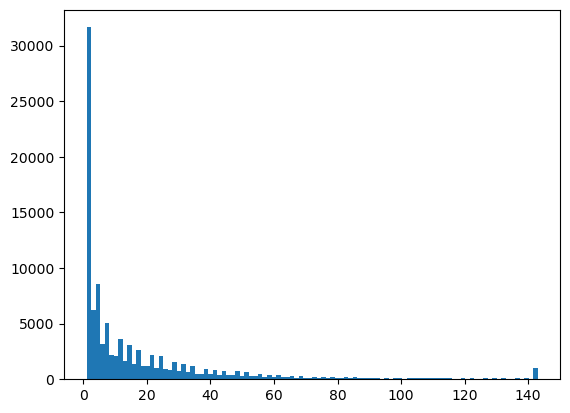

,name,year,percentage
0,Aaban,2007,0.000125
1,Aadam,2007,0.000200


,name,count
0,Aaban,13
1,Aabha,9


,name,year,percentage,count
0,Aaban,2007,0.000125,13
1,Aadam,2007,0.000200,31


size of the dataframe before filtering : 1903290
size of the dataframe before filtering : 1903290


,,percentage
name,year,
Aaron,2007,0.224338
Abbey,2007,0.008732


size of the dataframe after filtering : 755722


In [231]:
display(baby_name_df.head(2))
web_baby_name_df = baby_name_df[['percentage']].copy(deep=True)
display(web_baby_name_df.head(2))
web_baby_name_count = web_baby_name_df.groupby(['name']).count()
web_baby_name_count.rename(columns={"percentage": "count"}, inplace=True)
display(web_baby_name_count.head(2))
plt.hist(web_baby_name_count['count'], bins=100)
plt.show()

# merging
web_baby_name_df.reset_index(inplace=True)
web_baby_name_count.reset_index(inplace=True)
display(web_baby_name_df.head(2))
display(web_baby_name_count.head(2))
web_name_by_movie_df_merged = web_baby_name_df.merge(web_baby_name_count, on='name', how='left').copy(deep=True)
display(web_name_by_movie_df_merged.head(2))

# filtering
print(f"size of the dataframe before filtering : {len(baby_name_df)}")
print(f"size of the dataframe before filtering : {len(web_name_by_movie_df_merged)}")
web_baby_name_df = web_name_by_movie_df_merged[web_name_by_movie_df_merged['count'] >= 60].copy(deep=True)
web_baby_name_df.drop(columns=['count'], inplace=True)
web_baby_name_df.set_index(['name', 'year'], inplace=True)
display(web_baby_name_df.head(2))
print(f"size of the dataframe after filtering : {len(web_baby_name_df)}")

### Creation of the TOP5/5NULLFAMOUS/BOTTOM5
We need also a dataframe containing for each name in the `baby_name` dataset, 10 years where a variation of the baby names are significant (5 with the largest positive variation and 5 with the largest negative variation) as well as 5 popular movies where the variation is not significant.

In [232]:
display(name_by_movie_slope_diff_df.sample(2))

,,,order,p_value,slope_change,t_stat
wiki_ID,char_words,gender,,,,
24152381,Benton,M,7.0,0.502353,0.00013,-0.69354
11036762,President,F,NaN,NaN,NaN,NaN


Let's remove the gender because we won't consider it

In [233]:
# drop gender column
len_before = len(name_by_movie_slope_diff_df)
name_by_movie_slope_diff_without_gender_df = name_by_movie_slope_diff_df.copy(deep=True)
name_by_movie_slope_diff_without_gender_df.reset_index(inplace=True)
name_by_movie_slope_diff_without_gender_df.drop_duplicates(subset=['wiki_ID', 'char_words'], keep='first', inplace=True)
name_by_movie_slope_diff_without_gender_df.drop(columns=['gender'], inplace=True)
len_after = len(name_by_movie_slope_diff_without_gender_df)
print(f"length before : {len_before}")
print(f"length after : {len_after}")
display(name_by_movie_slope_diff_without_gender_df.sample(2))

length before : 172906
length after : 167984


,wiki_ID,char_words,order,p_value,slope_change,t_stat
134301,22982069,Sumi,NaN,NaN,NaN,NaN
13749,430975,Jensen,1.0,0.4705,0.00049,-0.747396


In [234]:
# drop useless columns
name_by_movie_with_slope_only = name_by_movie_slope_diff_without_gender_df.drop(columns=['order', 'p_value', 't_stat']).copy(deep=True)
display(name_by_movie_with_slope_only.sample(2))

,wiki_ID,char_words,slope_change
61991,4290149,Ton,NaN
170115,34344124,Lloyd,-0.000251


Now let's tackle the computing of the 5 TOP and 5 BOTTOM years with the most variation per names

In [235]:
movie_id_and_year_df = movie_df[['wiki_ID', 'year']].copy(deep=True)
display(movie_id_and_year_df.sample(2))

,wiki_ID,year
62764,34785654,1939
25816,6185648,1980


In [236]:
# merge the release year into the name_by_movie_with_slope_only dataframe
name_by_movie_with_slope_and_year = name_by_movie_with_slope_only.merge(movie_id_and_year_df, on='wiki_ID', how='left').copy(deep=True)
display(name_by_movie_with_slope_and_year.sample(2))

# check for a specific name and year
name_by_movie_with_slope_and_year.set_index(['char_words', 'year'], inplace=True)
display(name_by_movie_with_slope_and_year.loc['Elizabeth', 2004]) # ok, everything is fine
name_by_movie_with_slope_and_year.reset_index(inplace=True)

,wiki_ID,char_words,slope_change,year
47223,2748374,Dev,NaN,2002
121767,20993998,Walter,0.000887,1948


C:\Users\m_the\AppData\Local\Temp\ipykernel_23104\4271432590.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  display(name_by_movie_with_slope_and_year.loc['Elizabeth', 2004]) # ok, everything is fine


wiki_ID  slope_change
char_words year                        
Elizabeth  2004    474527      0.003704
           2004    974374      0.003704
           2004   1137578      0.003704
           2004   1749535      0.003704
           2004   2157292      0.003704
           2004  10862318      0.003704
           2004  17183671      0.003704
           2004  19417127      0.003704

In [237]:
display(name_by_movie_with_slope_and_year.head(2))
name_by_year_with_slop_change = name_by_movie_with_slope_and_year.drop_duplicates(subset=['char_words', 'year'], keep='first').copy(deep=True)
name_by_year_with_slop_change.drop(columns=['wiki_ID'], inplace=True)
display(name_by_year_with_slop_change.head(2))

,char_words,year,wiki_ID,slope_change
0,Gold,1992,3217,NaN
1,Linda,1992,3217,-0.000675


,char_words,year,slope_change
0,Gold,1992,NaN
1,Linda,1992,-0.000675


In [238]:
# Find the top and bottom 5 years for each name
top_5_years = name_by_year_with_slop_change.groupby('char_words').apply(lambda x: x.nlargest(5, 'slope_change')).reset_index(drop=True)
bottom_5_years = name_by_year_with_slop_change.groupby('char_words').apply(lambda x: x.nsmallest(5, 'slope_change')).reset_index(drop=True)

# Add a column indicating whether it is a top or bottom year
top_5_years['top_or_bottom'] = 'top'
bottom_5_years['top_or_bottom'] = 'bottom'

# Concatenate the two DataFrames
top_bottom_df = pd.concat([top_5_years, bottom_5_years], ignore_index=True)

# Drop the column used for sorting and set the index columns
# top_bottom_df.drop(columns=['slope_change'], inplace=True)
top_bottom_df.set_index(['char_words', 'top_or_bottom'], inplace=True)

display(top_bottom_df)

year  slope_change
char_words top_or_bottom                    
Aabid      top            2004           NaN
Aadam      top            2012     -0.000029
Aadhavan   top            2009           NaN
Aadhi      top            2006           NaN
Aadi       top            2002           NaN
...                        ...           ...
Zuzana     bottom         2011           NaN
Zuzu       bottom         1990           NaN
           bottom         2004           NaN
Zvi        bottom         2007           NaN
Zygmunt    bottom         1975           NaN

[81554 rows x 2 columns]

In [253]:
# check TOP 5 and BOTTOM 5 computation with a specific name
name_by_year_with_slop_change.reset_index(inplace=True)
name_by_year_with_slop_change.set_index(['char_words', 'year'], inplace=True)
display(name_by_year_with_slop_change)
display(name_by_year_with_slop_change.loc['Elizabeth', :])

import plotly.express as px

# Create a scatter plot using Plotly Express
fig = px.scatter(name_by_year_with_slop_change.loc['Elizabeth', :].reset_index(), x='year', y='slope_change', title='Interactive Scatter Plot', labels={'X': 'X-axis', 'Y': 'Y-axis'})

# Add cursor tooltip
fig.update_layout(hovermode='closest')

# Show the plot
fig.show()

display(top_bottom_df.loc['Elizabeth', :])

,,slope_change
char_words,year,
Gold,1992,NaN
Linda,1992,-0.000675
Henry,1992,-0.002435
Duke,1992,0.000108
Warrior,1992,NaN
...,...,...
Corliss,1949,NaN
Carlina,2012,0.000042
Samar,2012,-0.000242


,slope_change
year,
1961,0.006229
2000,-0.001445
1969,0.007387
2001,0.001978
1940,-0.000193
...,...
1926,-0.003332
2011,-0.009782
1982,0.033830


,year,slope_change
top_or_bottom,,
top,1910,0.056377
top,1982,0.033830
top,1983,0.033721
top,1985,0.030818
top,1984,0.029215
bottom,1974,-0.035449
bottom,1976,-0.035054
bottom,1973,-0.033223
bottom,1972,-0.019676


In [301]:
# Check passed, we can drop the column slope_change
top_bottom_df.drop(columns=['slope_change'], inplace=True)

Now, for each name in the `web_name_by_movie` dataframe, we gather all the movies that have this name for one of its character and that are not significant. Then we take the first 5 of this list and add it into a new dataframe called `5_famous_movies_but_unsignificant_by_name`

We reuse the dataframe `name_by_movie_slope_diff_without_gender_df` computed above.

In [302]:
display(name_by_movie_slope_diff_without_gender_df.head())
print(f"Length before : {len(name_by_movie_slope_diff_without_gender_df)}")

# first we can remove all the rows where the p_value is a NaN
name_by_movie_slope_diff_without_gender_filtered = name_by_movie_slope_diff_without_gender_df.copy(deep=True)
name_by_movie_slope_diff_without_gender_filtered.dropna(subset=['p_value'], inplace=True)
# we can remove the columsn we don't need
name_by_movie_slope_diff_without_gender_filtered.drop(columns=['order', 'slope_change', 't_stat'], inplace=True)
display(name_by_movie_slope_diff_without_gender_filtered.head())
print(f"Length after : {len(name_by_movie_slope_diff_without_gender_filtered)}")

print(f"Length before : {len(name_by_movie_slope_diff_without_gender_df)}")
# keep only non-significent rows
name_by_movie_non_significent = name_by_movie_slope_diff_without_gender_filtered[name_by_movie_slope_diff_without_gender_filtered['p_value'] >= 0.1].copy(deep=True)
name_by_movie_non_significent.drop(columns=['p_value'], inplace=True)
display(name_by_movie_non_significent.head())
print(f"Length after : {len(name_by_movie_non_significent)}")

,wiki_ID,char_words,order,p_value,slope_change,t_stat
0,3217,Gold,6.0,NaN,NaN,NaN
1,3217,Linda,7.0,0.676072,-0.000675,0.429187
2,3217,Henry,4.0,0.068422,-0.002435,2.019954
3,3217,Duke,4.0,0.582585,0.000108,-0.566260
4,3217,Warrior,9.0,NaN,NaN,NaN


Length before : 167984


,wiki_ID,char_words,p_value
1,3217,Linda,0.676072
2,3217,Henry,0.068422
3,3217,Duke,0.582585
7,3217,Williams,0.927756
9,3217,Sheila,0.934247


Length after : 116464
Length before : 167984


,wiki_ID,char_words
1,3217,Linda
3,3217,Duke
7,3217,Williams
9,3217,Sheila
10,3217,Arthur


Length after : 93152


In [303]:
# add the attribute 'numVotes' from the movie_df dataframe with a merge
temp_merge_df = movie_df[['wiki_ID', 'numVotes']].copy(deep=True)
display(temp_merge_df.head())
name_by_movie_non_significent_with_numvotes = name_by_movie_non_significent.merge(temp_merge_df, on='wiki_ID', how='left').copy(deep=True)
display(name_by_movie_non_significent_with_numvotes.head())
print(f"length of name_by_movie_non_significent_with_numvotes : {len(name_by_movie_non_significent_with_numvotes)}")

,wiki_ID,numVotes
0,975900,56880
1,3196793,69
2,28463795,40
3,9363483,2891
4,261236,623


,wiki_ID,char_words,numVotes
0,3217,Linda,191068
1,3217,Duke,191068
2,3217,Williams,191068
3,3217,Sheila,191068
4,3217,Arthur,191068


length of name_by_movie_non_significent_with_numvotes : 93152


In [304]:
# Sorting the DataFrame by 'name' and 'scores' in descending order
# df_sorted = name_by_movie_non_significent_with_numvotes.sort_values(by=['char_words', 'numVotes'], ascending=[True, False])
name_by_movie_non_significent_with_numvotes_sorted = name_by_movie_non_significent_with_numvotes.sort_values(by='numVotes', ascending=False).copy(deep=True)
display(name_by_movie_non_significent_with_numvotes_sorted.head())

# Extracting the top 5 rows for each 'name'
top5_famous_movie_insignificant_by_name = name_by_movie_non_significent_with_numvotes_sorted.groupby('char_words').head(5).copy(deep=True)
top5_famous_movie_insignificant_by_name.set_index(['char_words'], inplace=True)
top5_famous_movie_insignificant_by_name.drop(columns=['numVotes'], inplace=True)
display(top5_famous_movie_insignificant_by_name.head())

,wiki_ID,char_words,numVotes
507,30625,Andy,2815221
512,30625,Ernie,2815221
511,30625,Boyd,2815221
510,30625,Floyd,2815221
509,30625,Ellis,2815221


,wiki_ID
char_words,
Andy,30625
Ernie,30625
Boyd,30625
Floyd,30625
Ellis,30625


### Export the data

In [305]:
processed_website_data_folder = './processed_data/website/'

display(web_name_by_movie_df.reset_index().head())
# Export DataFrame to a CSV file in the processed data folder
web_name_by_movie_df.reset_index().to_csv(os.path.join(processed_website_data_folder, 'web_name_by_movie_df.csv'), index=False)

display(web_baby_name_df.reset_index().head())
# Export DataFrame to a CSV file in the processed data folder
web_baby_name_df.reset_index().to_csv(os.path.join(processed_website_data_folder, 'web_baby_name_df.csv'), index=False)

display(top_bottom_df.reset_index().head())
# Export DataFrame to a CSV file in the processed data folder
top_bottom_df.reset_index().to_csv(os.path.join(processed_website_data_folder, 'web_top_bottom_df.csv'), index=False)

display(top5_famous_movie_insignificant_by_name.reset_index().head())
# Export DataFrame to a CSV file in the processed data folder
top5_famous_movie_insignificant_by_name.reset_index().to_csv(os.path.join(processed_website_data_folder, 'web_top_famous_but_insi.csv'), index=False)

,level_0,index,char_words,wiki_ID,mov_name,year,averageRating,numVotes,poster_url
0,0,0,Andy,30625,The Shawshank Redemption,1994,9.3,2815221,https://images-na.ssl-images-amazon.com/images...
1,1,1,Heywood,30625,The Shawshank Redemption,1994,9.3,2815221,https://images-na.ssl-images-amazon.com/images...
2,2,2,Diamond,30625,The Shawshank Redemption,1994,9.3,2815221,https://images-na.ssl-images-amazon.com/images...
3,3,3,Redding,30625,The Shawshank Redemption,1994,9.3,2815221,https://images-na.ssl-images-amazon.com/images...
4,4,4,Ellis,30625,The Shawshank Redemption,1994,9.3,2815221,https://images-na.ssl-images-amazon.com/images...


,name,year,percentage
0,Aaron,2007,0.224338
1,Abbey,2007,0.008732
2,Abbie,2007,0.011710
3,Abbott,2007,0.000375
4,Abby,2007,0.039683


,char_words,top_or_bottom,year
0,Aabid,top,2004
1,Aadam,top,2012
2,Aadhavan,top,2009
3,Aadhi,top,2006
4,Aadi,top,2002


,char_words,wiki_ID
0,Andy,30625
1,Ernie,30625
2,Boyd,30625
3,Floyd,30625
4,Ellis,30625


# Test the ploting

There are 143 years with a character named Thomas. 
The earliest year is 1880 and the latest is 2022.


Text(0.5, 1.0, 'Name "Thomas"')

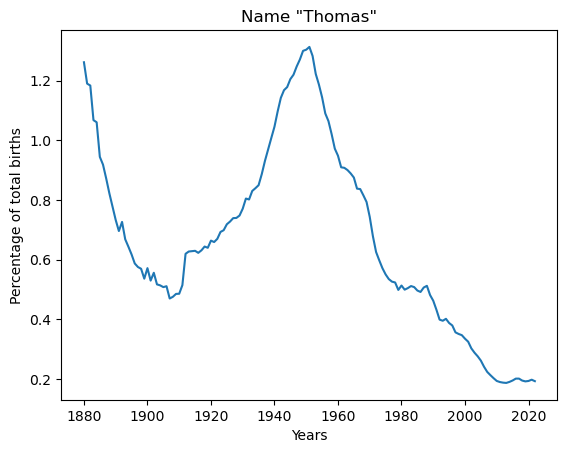

In [172]:
chosen_name = 'Thomas'

percentage_df = baby_name_df.loc[chosen_name][['percentage']].reset_index()
percentage_df.sort_values(by=['year'], ascending=True, inplace=True)
print(f"There are {len(percentage_df)} years with a character named {chosen_name}. \nThe earliest year is {percentage_df['year'].min()} and the latest is {percentage_df['year'].max()}.")

x_values = percentage_df['year'].values
y_values = percentage_df['percentage'].values

# Ploting
plt.plot(x_values, y_values)
plt.xlabel('Years')
plt.ylabel('Percentage of total births')
plt.title(f'Name "{chosen_name}"')

In [173]:
# filter the name_by_movie and keep only name_by_movie where the movie have the most ratings in the release year and remove all the other nam_by_movie released that year.
# for each name divide the years into three dataframes, one for significant increase, one for significant decrease, and one one without significance. Rank these dataframes based on the t-statistic modulusne for no change (use p-value and t-statistic. Then get the top five of the three dataframes for each name.